## ** An Experimental Study on Performance of Non-intrusive Load Monitoring **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * NILM model results cannot be used directly, so they must be post-processed.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

In [1]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

/home/kgbmanse/anaconda3/envs/nilm/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Configuration

In [2]:
###############################################################
# Common
###############################################################

# 6s
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/enertalk.h5'

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

HOME_ID = 1
appliances = ['washing machine', 'rice cooker', 'microwave']

## Result Processing

- Description
  The find_peaks function in the Python scipy package was used to identify when the appliance was activated. The proper input parameters were set to detect peaks that indicated appliance operation.
  * For example, washing machines were determined to be operating if they were consuming at least 50% of their maximum energy consumption, which can be acquired during training or through other methods (height). Setting this limit filtered out predictions based on small amounts of energy consumed that would make the model less accurate. Peaks also had to occur for at least 10 minutes (width)
  * For the rice cooker, a minimum interval between activations was set to 20 minutes (distance), which was usually because the appliance was not used continuously at short intervals of time. Since the rice cooker continues to use power to keep warm even after cooking, it is not recommended to specify the width parameter corresponding to the peak duration
  * The parameters used for rice cooker were adopted to detect microwave activation, which is because both as cooking appliances were expected to show similar usage patterns  

********************
[DRF-washing machine]
********************


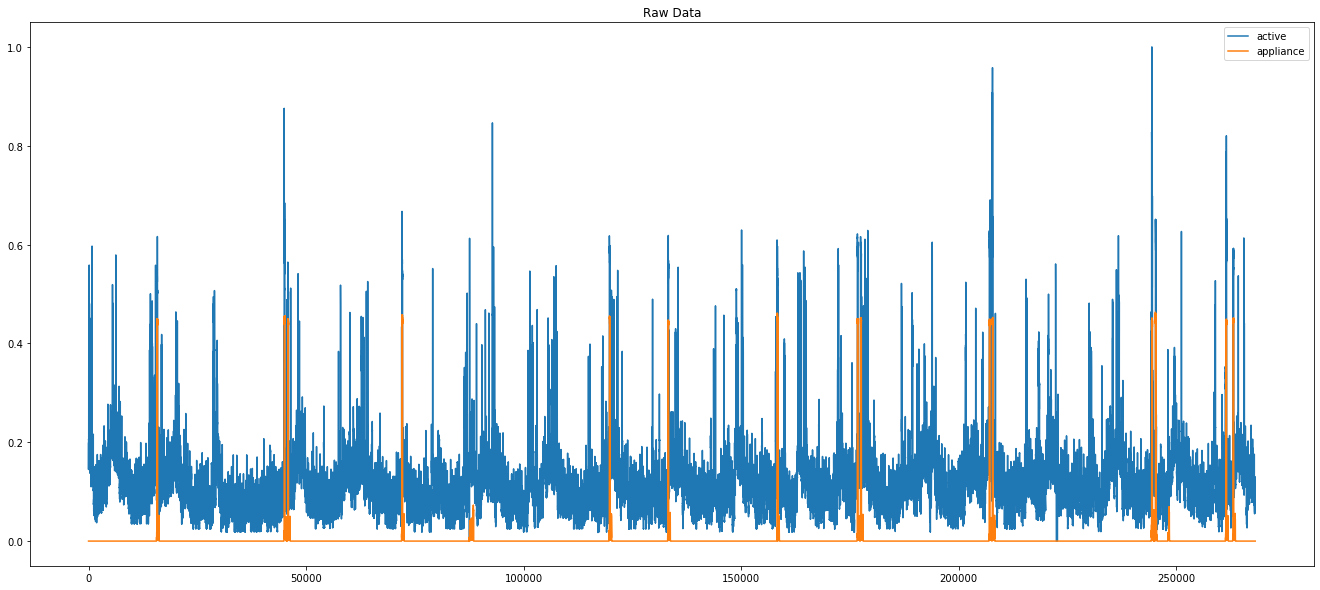

feature selection is done..
model fit is done..
min     0.864034
diff    0.033191
a9      0.033001
q0      0.009177
std     0.006994
max     0.006566
a0      0.005540
q1      0.004314
a8      0.004240
f5      0.002873
q2      0.002513
a1      0.001999
a6      0.001949
f1      0.001912
a7      0.001886
a2      0.001771
f7      0.001757
f9      0.001702
f3      0.001576
a5      0.001549
f6      0.001536
a3      0.001517
f2      0.001469
mean    0.001462
f8      0.001454
f4      0.001435
f0      0.001399
a4      0.001185
dtype: float64


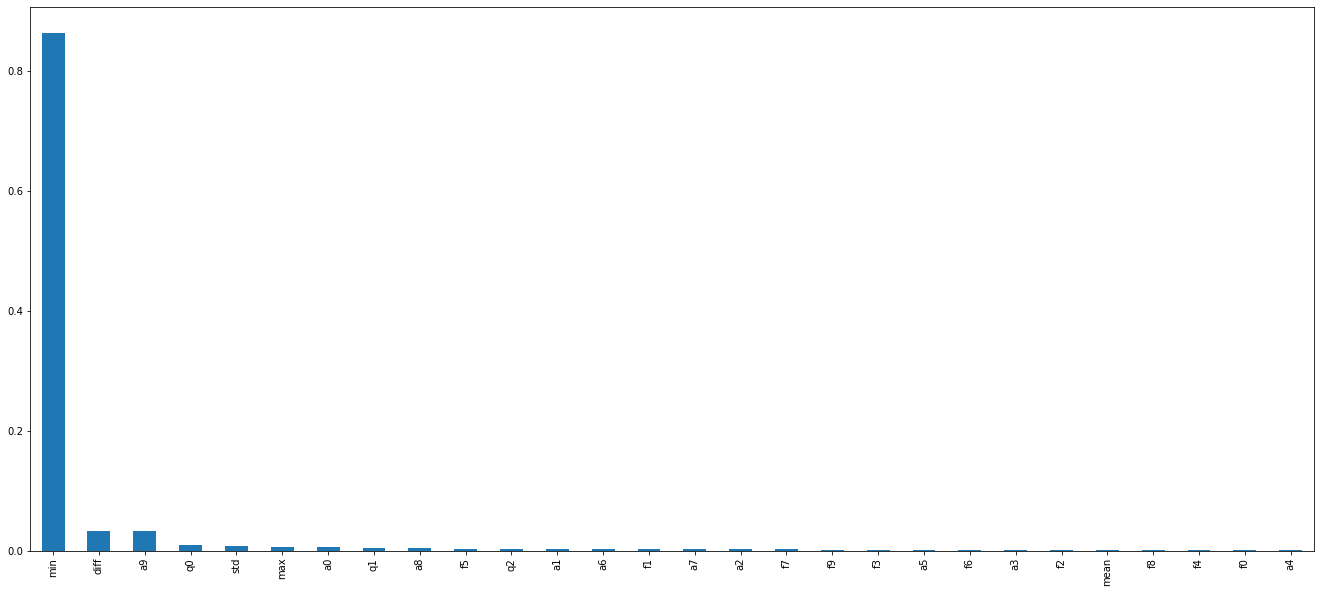

train on chunk is done..
elapsed time (secs) = 2111.422320127487
********************
[DRF-rice cooker]
********************


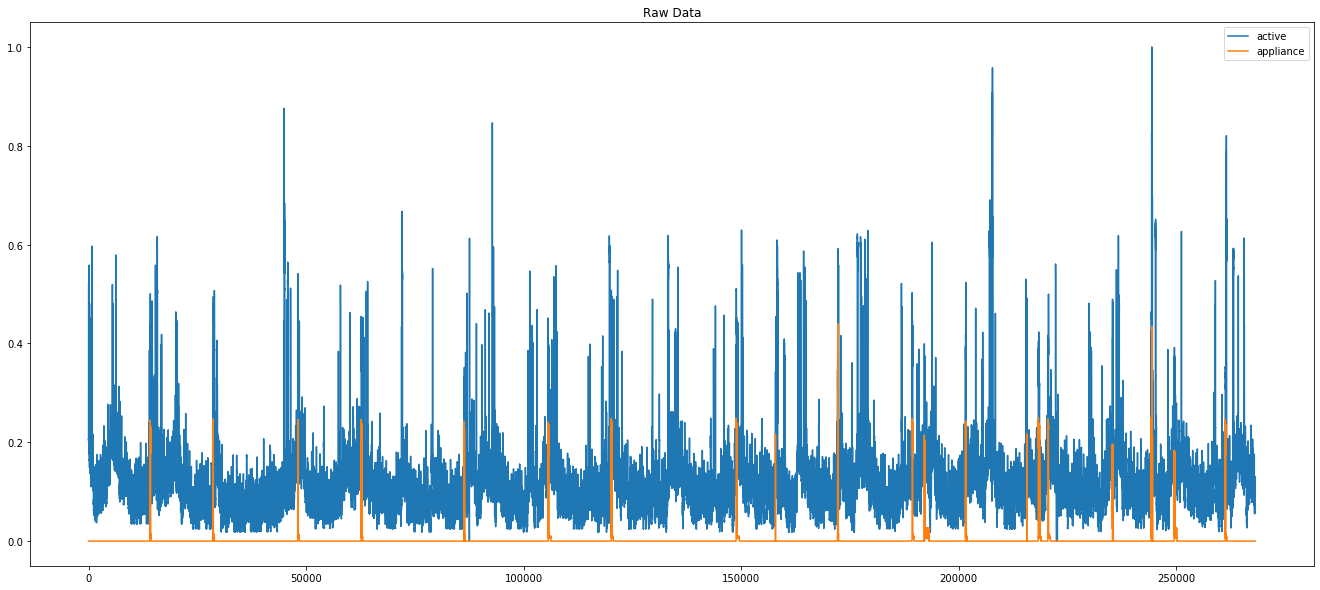

feature selection is done..
model fit is done..
a9      0.459232
min     0.092730
diff    0.079875
a1      0.058459
std     0.054418
max     0.048154
a8      0.039631
q2      0.018005
q0      0.017612
a0      0.014620
q1      0.014007
f5      0.010172
a7      0.007941
f9      0.007835
f1      0.007026
a2      0.006786
f6      0.006232
f4      0.006211
a5      0.005980
a6      0.005816
f3      0.005450
f7      0.005413
f8      0.004899
a3      0.004891
f2      0.004874
mean    0.004778
f0      0.004634
a4      0.004320
dtype: float64


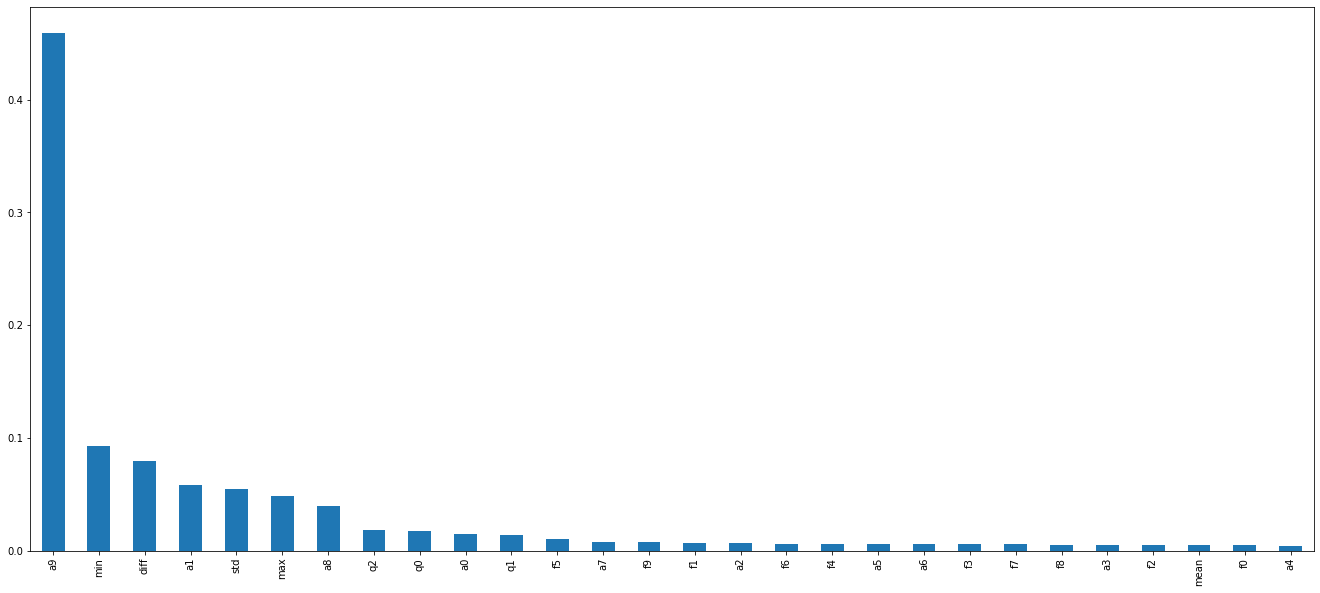

train on chunk is done..
elapsed time (secs) = 1961.0505657196045
********************
[DRF-microwave]
********************


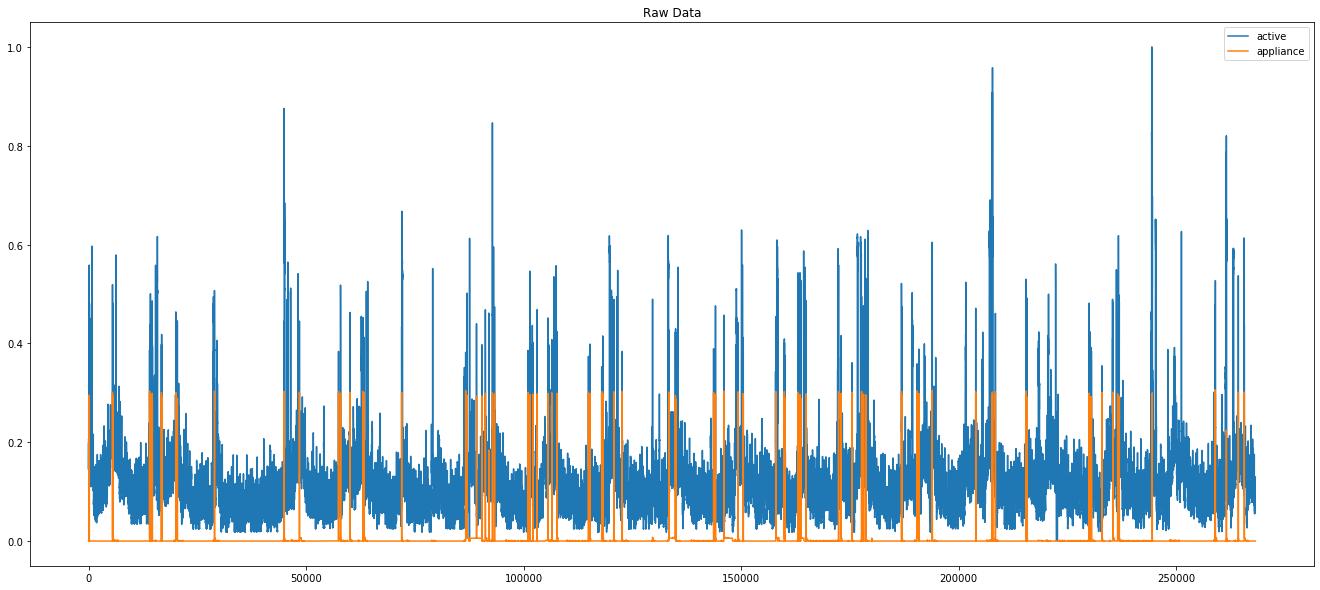

feature selection is done..
model fit is done..
diff    0.334153
a9      0.141353
f6      0.074729
f4      0.068392
a8      0.045220
q0      0.043345
max     0.039862
min     0.034828
f5      0.033596
std     0.027808
a7      0.015307
a0      0.014609
q2      0.012227
a1      0.011151
q1      0.009593
a5      0.009525
f7      0.008722
a2      0.008554
f1      0.008496
f3      0.008272
a3      0.007797
f9      0.007664
f2      0.007207
a4      0.007090
f8      0.006228
a6      0.005671
f0      0.004751
mean    0.003849
dtype: float64


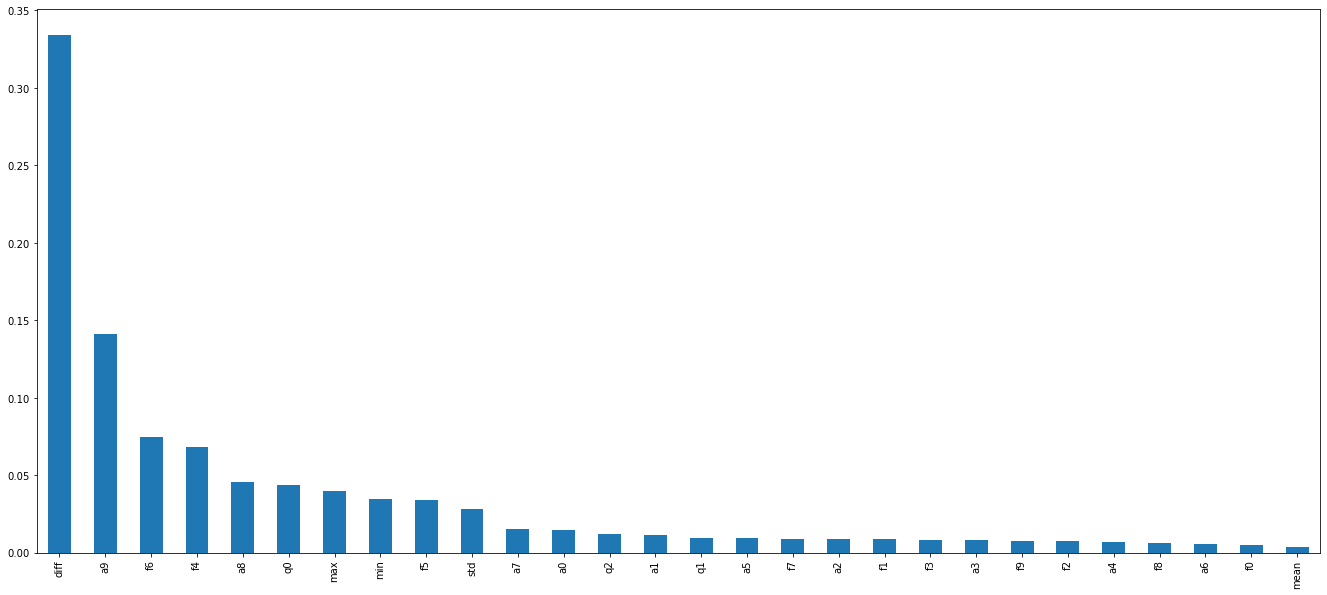

train on chunk is done..
elapsed time (secs) = 1914.5947635173798


In [3]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

models = {}

for aname in appliances:
    
    try:
    
        train_meter = train_elec.submeters()[aname]
        
        mname = 'DRF-' + aname

        models[mname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
        
        print("*"*20)
        print("[" + mname + "]") 
        print("*" *20)

        start = time.time()
        models[mname].train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        end = time.time()            
        print("elapsed time (secs) = " + str(end-start))
        
    except Exception as e:
        print('train error', e)   

In [16]:
def count_num_of_activations(total, predicted, ground_truth, appliance_max):
    
    #least_amount = appliance_max / 10
    least_amount = appliance_max / 2
    
    legends = []
    
    t = total.power_series_all_data()    
    #plt.plot(t, linewidth=2)
    #legends.append('total')
    
    if ground_truth is not None:
        gt = ground_truth.power_series_all_data()        
        plt.plot(gt, linewidth=2)
        legends.append('appliance (actual)')
    
    pred = predicted.power_series_all_data()
    plt.plot(pred, linewidth=2)
    legends.append('appliance (predicted)')    
    
    print(type(pred))
    
    # washing machine : height=50%, width=100, prominence = 1
    # rice cooker : height=50%, distance=200, prominence = 1
    # microwave : height=50%, width=2, distance=200, prominence = 1 
    peaks, properties = find_peaks(pred, height=least_amount, distance=200, prominence=1)  

    print(f'activations : {peaks}')

    print(np.diff(peaks))
    
    plt.plot(pred.index[peaks], pred[peaks], "o")
    plt.legend(legends)        
    plt.show()    
    
    return len(peaks)

In [17]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
    return count_num_of_activations(test_mains, predicted, ground_truth, model.meter_mmax)

********************
[DRF-washing machine]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.5832869080779944
============ Precision: 0.620260663507109
============ Accuracy: 0.9035416666666667
============ F1 Score: 0.6012058570198106
============ Relative error in total energy: 0.06027240355288029
============ Mean absolute error(in Watts): 11.90536505803489
<class 'pandas.core.series.Series'>
activations : [ 5398  6368  7374 12089]
[ 970 1006 4715]


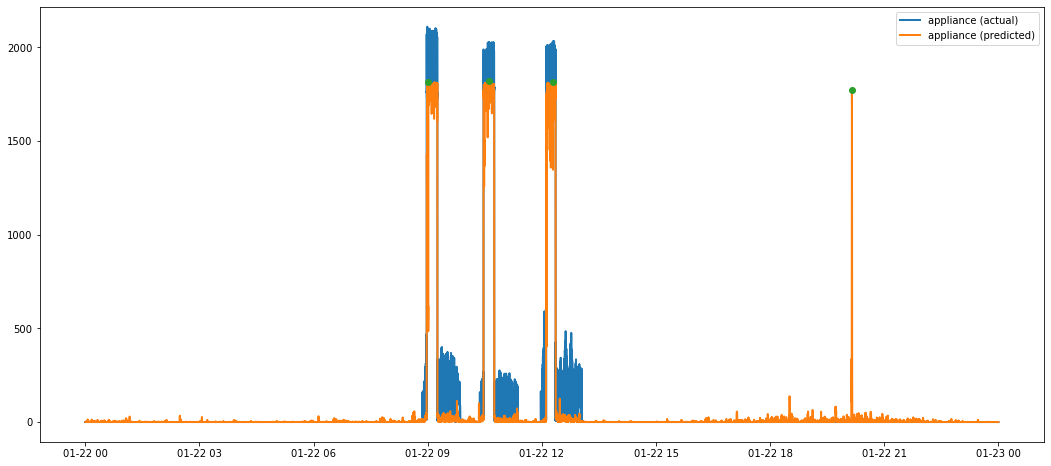

********************
[DRF-rice cooker]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.44699367088607594
============ Precision: 0.6958128078817734
============ Accuracy: 0.9343055555555555
============ F1 Score: 0.5443159922928709
============ Relative error in total energy: 0.16961384967740673
============ Mean absolute error(in Watts): 6.611070800319998
<class 'pandas.core.series.Series'>
activations : [ 5230 11929]
[6699]


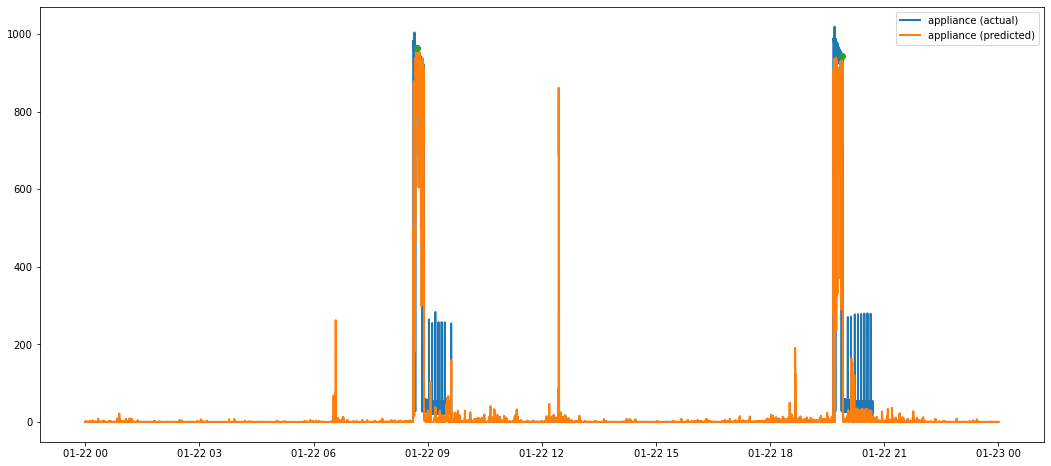

********************
[DRF-microwave]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.1190721649484536
============ Precision: 0.4052631578947368
============ Accuracy: 0.8577777777777778
============ F1 Score: 0.18406374501992032
============ Relative error in total energy: 0.09629116462112527
============ Mean absolute error(in Watts): 7.761000561698304
<class 'pandas.core.series.Series'>
activations : [ 5444  5769  7460 11099 11820 12131 12421]
[ 325 1691 3639  721  311  290]


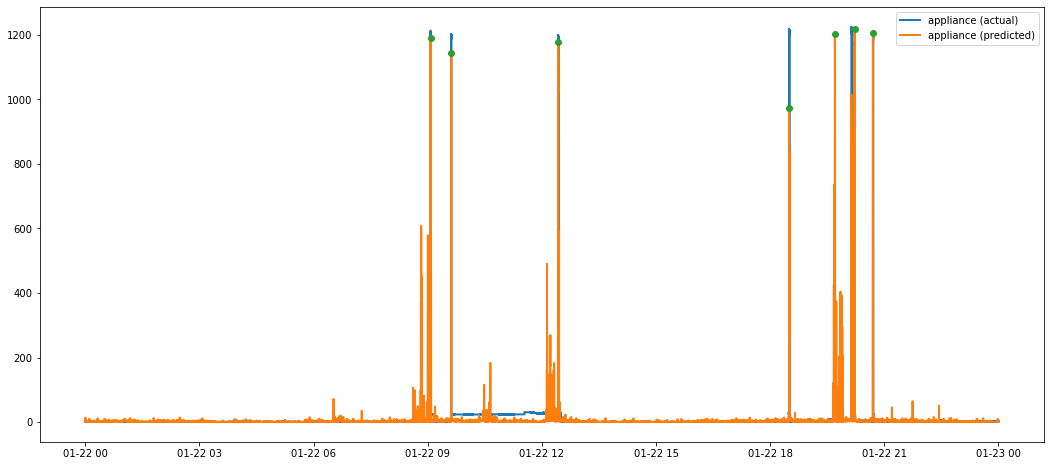

In [18]:
P_S = '2017-01-22 00:00:00'
P_E = '2017-01-23 00:00:00'

rcParams['figure.figsize'] = (18, 8)

for mname, model in models.items():

    try:

        print("*"*20)
        print("[" + mname + "]") 
        print("*" *20)

        num_of_activations = disaggregate(dataset, model, mname[4:], P_S, P_E, True)

    except Exception as e:
        print('train & test error', e)

rcParams['figure.figsize'] = (23, 10)